In [1]:
pip install warmup_scheduler_pytorch


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import numpy as np
import pandas as pd
# image manipulation
import cv2
import PIL
from PIL import Image

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# helpers
from tqdm.notebook import tqdm
import time
import copy
import gc
from enum import Enum

# sklearn
from sklearn.model_selection import KFold

# for cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, ExponentialLR, CosineAnnealingLR
from torchvision import models
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryROC, BinaryAUROC, BinaryPrecisionRecallCurve
from torchvision import transforms
from warmup_scheduler_pytorch import WarmUpScheduler


In [3]:
torch.manual_seed(0)

In [4]:
csvpathtrain = '/kaggle/input/rsna-breast-cancer-detection/train.csv'

dftrain = pd.read_csv(csvpathtrain)
dftrain.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Text(0.5, 0.98, 'Cancer distribution')

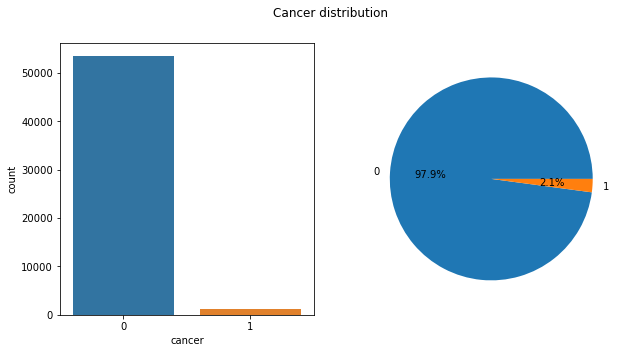

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
########## PLOTING CANCER ################
splot = sns.countplot(ax = axes[0], x = dftrain['cancer'])

s = dftrain['cancer'].value_counts()
axes[1].pie(s, autopct="%.1f%%", labels = s.keys())
fig.suptitle('Cancer distribution')

In [6]:
total_samples = len(dftrain['cancer'])
positive_samples = sum(dftrain['cancer'] == 1)
negative_samples = total_samples - positive_samples
print(f"{total_samples}, {positive_samples}, {negative_samples}")

54706, 1158, 53548


In [7]:
class RSNAMamographyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.df = pd.read_csv(annotations_file)
        # MODIFICATION. Drop all difficult negative casses
        # self.df = self.df.drop(self.df[self.df['difficult_negative_case'] == 1].index)
        
        self.df = self.df.drop(self.df[self.df['image_id'] == 1942326353].index) # image is totally white
        self.df = self.df.drop(self.df[self.df['patient_id'] == 27700].index) # images are noise

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    


    def __getitem__(self, ind):
        
        img_path = f"{self.img_dir}/{self.df.iloc[ind].patient_id}_{self.df.iloc[ind].image_id}.png"
        img = Image.open(img_path).convert('RGB')
        
        label = self.df.iloc[ind].cancer
        # there is no need to normalize data, it has already been normalized
        if self.transform:
            img = self.transform(img).to(torch.float32) 
        else:
            default_transform = transforms.Compose([transforms.ToTensor()])
            img = default_transform(img).to(torch.float32)
            
        #sample = {"image" : img, "label": label}
        return img, label

In [8]:
train_csv = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
imgs_dir = '/kaggle/input/rsnamamorgaphybreastcancerrecognition512x512'

augmentator = transforms.Compose([
    # input for augmentator is always PIL image
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(), # return it as a tensor and transforms it to [0, 1]
])
dataset = RSNAMamographyDataset(train_csv, imgs_dir, augmentator)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is {device}')

Current device is cuda


In [10]:
class CNN(nn.Module):
    def __init__(self, n = 5):
        super(CNN, self).__init__()
        self.network = models.resnext50_32x4d(pretrained = True)
        
        
        # freeze first n layers
        ct = 0
        #if n:
            #print('FREEZED LAYERS:')
        for child in self.network.children():
            ct += 1
            if ct <= n:
                #print('*'*100)
                #print(child)

                for param in child.parameters():
                    param.requires_grad = False

        n_features = self.network.fc.out_features
        # add additional layer that maps 2048 extracted features from resnet to 1 feature determining the class
        self.classifier_layer = nn.Sequential(
            nn.Linear(n_features , 64),
            nn.Dropout(0.3),
            nn.Linear(64 , 1)
        )
    
    def forward(self, xb):        
        xb = self.network(xb)
        xb = self.classifier_layer(xb)
        return torch.sigmoid(xb)

In [11]:
# create class for earlystopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = np.inf

    def early_stop(self, loss):
        if loss <= self.min_loss:
            self.min_loss = loss
            self.counter = 0
        elif loss > (self.min_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
def BCELoss_class_weighted(weights):
    """
    weights[0] is weight for class 0 (negative class)
    weights[1] is weight for class 1 (positive class)
    """
    def loss(y_pred, target):
        y_pred = torch.clamp(y_pred,min=1e-7,max=1-1e-7) # for numerical stability
        bce = - weights[1] * target * torch.log(y_pred) - (1 - target) * weights[0] * torch.log(1 - y_pred)
        return torch.mean(bce)

    return loss

In [13]:
def initialize_model(n_epochs):
    # defining the model
    model = CNN()
    model.to(device)


    # Try this initial LR
    init_lr = 4e-05
    # defining the optimizer
    optimizer = Adam(model.parameters(), lr=init_lr)
    
    w_pos = 3
    w_neg = 1
    #print(f"Class weight for negative class: {w_neg}, and for positive {w_pos}")
    criterion = BCELoss_class_weighted(weights = [w_neg, w_pos])
    #criterion = nn.BCEWithLogitsLoss()
    # define early stopping
    earlystop = EarlyStopper(patience = 3)


    checkpoint = {'model': CNN(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict(),
                 'threshold' : 0.5}


    #lr_scheduler = ExponentialLR(optimizer, gamma = 0.85, last_epoch=- 1, verbose=False)
    lr_scheduler = CosineAnnealingLR(optimizer, n_epochs, last_epoch = -1)
    # define lr scheduler
    warmup_scheduler = WarmUpScheduler(optimizer, lr_scheduler,
                                       warmup_steps=1,
                                       warmup_start_lr=init_lr/5,
                                       warmup_mode='linear')
    
    return model, optimizer, warmup_scheduler, earlystop, criterion, checkpoint

In [14]:
def find_optim_thres(fpr, tpr, thresholds):
    optim_thres = thresholds[0]
    inx = 0
    min_dist = 1.0
    for i in range(len(fpr)):
        dist = np.linalg.norm(np.array([0.0, 1.0]) - np.array([fpr[i], tpr[i]]))
        if dist < min_dist:
            min_dist = dist
            optim_thres = thresholds[i]
            inx = i
            
    return optim_thres, inx
        

In [15]:
import random

class KFoldSampler():
    def __init__(self, kfolds, shuffle = False):
        self.kfolds = kfolds
        self.shuffle = shuffle

        
        
    def split(self, dataset):
        inds = list(range(0, len(dataset)))

        if self.shuffle:
            random.shuffle(inds)
        folds = []
        val_fold_length = len(dataset) // self.kfolds
        for i in range(self.kfolds):
            val_inds = inds[i*val_fold_length:(i+1)*val_fold_length]
            train_inds = inds[:i*val_fold_length] + inds[(i+1)*val_fold_length:]
            val_dataset = torch.utils.data.Subset(dataset, val_inds)
            train_dataset = torch.utils.data.Subset(dataset, train_inds)
            
            folds.append((train_dataset, val_dataset))
        
        return folds

1
36470
18235
2
36470
18235
3
36470
18235


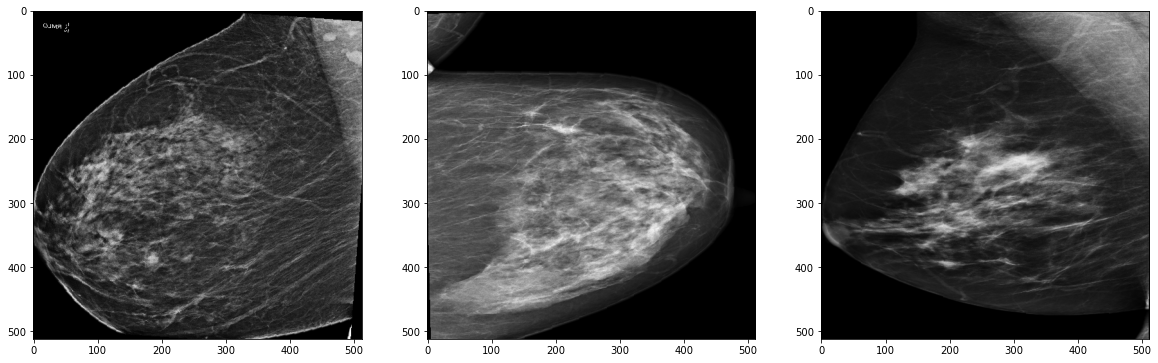

In [16]:
kfold = KFoldSampler(3, shuffle = True)

plt.subplots(1, 3, figsize = (20, 10))
for fold, (train_ds, val_ds) in enumerate(kfold.split(dataset)):
    print(fold + 1)
    print(len(train_ds))
    print(len(val_ds))
    img, label = val_ds[0]
    plt.subplot(1, 3, fold + 1)
    plt.imshow(img.permute(1, 2, 0))

In [17]:
def get_weighted_random_sampler(dataset):
    print("Class counting...")
    labels = dftrain['cancer'].values
    class_sample_count = np.array([len(np.where(labels == l)[0]) for l in np.unique(labels)])

    # to be closer to 'reality, every fifth image will be cancer (instead of 50/50 distribution)'
    class_sample_count[1] *= 5
    class_weights = 1. / class_sample_count

    print("Adding weights to each training sample...")
    sample_weights = [class_weights[label] for _, label in tqdm(dataset)]
    
    sample_weights = np.array(sample_weights)
    sample_weights = torch.from_numpy(sample_weights)
    
    weighted_random_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    return weighted_random_sampler

In [18]:
def train_model(num_epochs=25):
    since = time.time()
    
    metricf1 = BinaryF1Score()
    precision = BinaryPrecision()
    recall = BinaryRecall()
    accuracy = BinaryAccuracy()
    roc = BinaryROC()
    auc = BinaryAUROC()
    
   
    all_folds_metric = []
    
    
    # inital threshold for first epoch, it will change afterwards
    threshold = 0.5
    k_folds = 3
    kfold = KFoldSampler(k_folds, shuffle=True)
    
    print('Starting training...')
    print('-' * 20)
    for fold, (train_dataset, val_dataset) in enumerate(kfold.split(dataset)):
        print(len(train_dataset))
        print(len(val_dataset))
        print("-"*30)
        print("-"*30)

        print(f"Fold {fold + 1}")      

        train_metrics = {'loss' : [], 'acc' : [], 'f1': [], 'precision': [], 'recall': [], 'auc': [], 'lr': []}
        val_metrics = {'loss' : [], 'acc' : [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
        
        weighted_random_sampler = get_weighted_random_sampler(train_dataset)
        batch_size = 32

        train_dataloader = DataLoader(train_dataset, sampler = weighted_random_sampler, batch_size=batch_size, num_workers = 2, pin_memory = True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers = 2, pin_memory = True)

        dataloaders = {'train':train_dataloader, 'val' : val_dataloader}
        dataset_sizes = {'train': len(train_dataloader), 'val' : len(val_dataloader)}

        model, optimizer, scheduler, earlystop, criterion, checkpoint = initialize_model(num_epochs)
        
        best_model_wts = copy.deepcopy(model.state_dict())
        best_f1 = -1.0
        for epoch in range(num_epochs):


            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                # empty 'all' tensors for saving
                # for calculating aoc at the end of epoch, and for calculating new threshold
                all_outputs = torch.Tensor([])
                all_labels = torch.Tensor([])
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                n_samples = 0

                n_correct = 0
                running_f1 = 0.0
                # Iterate over data.
                print(f'{phase} for epoch {epoch + 1}')
                for inputs, labels in tqdm(dataloaders[phase]):

                    labels = torch.unsqueeze(labels.to(torch.float32), 1)

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        preds = (outputs > threshold).double()
                        #print(all_outputs)
                        #print(outputs)
                        # concatenating all outputs and labels for calculation aoc and new threshold
                        all_outputs = torch.cat((all_outputs, outputs.to('cpu')))
                        all_labels = torch.cat((all_labels, labels.to('cpu')))

                        #print(labels)
                        # _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    # n_samples += labels.size(0)
                    running_loss += loss.item()
                    # n_correct += (preds == labels).sum().item()
                    # running_f1 += metric(outputs, labels) 


                    # collect any unused memmory
                    gc.collect()
                    torch.cuda.empty_cache()

                # statistics
                epoch_loss = running_loss / len(dataloaders[phase])

                # find true positive and false positive rates for ROC curve
                fpr, tpr, thresholds = roc(all_outputs, all_labels)
                epoch_auc = auc(all_outputs, all_labels)
                # find new threshold
                if phase == 'train':
                    # just for train phase calculate threshold
                    threshold, _ = find_optim_thres(fpr, tpr, thresholds)
                    print(f'New threshold is {threshold}')
                # calculate metrics using new optimized threshold
                epoch_f1 = metricf1(all_outputs > threshold, all_labels)
                epoch_acc = accuracy(all_outputs > threshold, all_labels)
                epoch_precision = precision(all_outputs > threshold, all_labels)
                epoch_recall = recall(all_outputs > threshold, all_labels)

                # save all of the statistics for latter analysis
                if phase == 'train':
                    train_metrics['lr'].append(optimizer.param_groups[0]['lr'])
                    scheduler.step()
                    train_metrics['loss'].append(epoch_loss)
                    train_metrics['acc'].append(epoch_acc)
                    train_metrics['f1'].append(epoch_f1)
                    train_metrics['precision'].append(epoch_precision)
                    train_metrics['recall'].append(epoch_recall)
                    train_metrics['auc'].append(epoch_auc)


                else:
                    val_metrics['loss'].append(epoch_loss)
                    val_metrics['acc'].append(epoch_acc)
                    val_metrics['f1'].append(epoch_f1)
                    val_metrics['precision'].append(epoch_precision)
                    val_metrics['recall'].append(epoch_recall)
                    val_metrics['auc'].append(epoch_auc)



                # deep copy the model
                if phase == 'val' and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
                    # just for train phase calculate threshold
                    threshold, _ = find_optim_thres(fpr, tpr, thresholds)
                    print(f'New threshold for saving is {threshold}')
                    checkpoint['threshold'] = threshold
                    # save fold
                    torch.save(checkpoint, f'checkpoint{fold + 1}.pth')


            # cant be formated in string
            tr_loss, tr_acc, tr_f1, tr_prec, tr_rec, tr_auc = train_metrics['loss'][-1], train_metrics['acc'][-1],  train_metrics['f1'][-1], train_metrics['precision'][-1], train_metrics['recall'][-1], train_metrics['auc'][-1]
            val_loss, val_acc, val_f1, val_prec, val_rec, val_auc = val_metrics['loss'][-1], val_metrics['acc'][-1], val_metrics['f1'][-1], val_metrics['precision'][-1], val_metrics['recall'][-1], val_metrics['auc'][-1]
            lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch + 1}/{num_epochs}, learning rate: {lr}')
            print(f'Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f}, Train f1: {tr_f1:.4f}, Train Precision: {tr_prec:.4f}, Train Recall: {tr_rec:.4f}, Train AUC: {tr_auc:.4f}')
            print(f'Valitadion Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}, Vall f1: {val_f1:.4f}, Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}, Val AUC: {val_auc:.4f}')

            if earlystop.early_stop(val_loss):
                break
        all_folds_metric.append((train_metrics, val_metrics))
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best val f1: {best_f1:4f}')

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model, all_folds_metric

In [19]:
n_epochs = 5
batch_size = 32


In [20]:
model, all_folds_metric = train_model(num_epochs=n_epochs)

Starting training...
--------------------
36470
18235
------------------------------
------------------------------
Fold 1
Class counting...
Adding weights to each training sample...


  0%|          | 0/36470 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

train for epoch 1


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.378806471824646
val for epoch 1


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.279458224773407
Epoch 1/5, learning rate: 4.000000000000001e-05
Train Loss: 0.7468, Train Acc: 0.6783, Train f1: 0.4068, Train Precision: 0.2922, Train Recall: 0.6694, Train AUC: 0.7480
Valitadion Loss: 0.3377, Validation Acc: 0.8407, Vall f1: 0.1269, Val Precision: 0.0722, Val Recall: 0.5210, Val AUC: 0.7582
train for epoch 2


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.35265496373176575
val for epoch 2


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.0943770632147789
Epoch 2/5, learning rate: 3.618033988749896e-05
Train Loss: 0.5448, Train Acc: 0.7932, Train f1: 0.5635, Train Precision: 0.4322, Train Recall: 0.8093, Train AUC: 0.8843
Valitadion Loss: 0.2829, Validation Acc: 0.8863, Vall f1: 0.1430, Val Precision: 0.0859, Val Recall: 0.4272, Val AUC: 0.7731
train for epoch 3


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.3544768989086151
val for epoch 3


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.021151520311832428
Epoch 3/5, learning rate: 2.6180339887498954e-05
Train Loss: 0.2821, Train Acc: 0.9082, Train f1: 0.7664, Train Precision: 0.6586, Train Recall: 0.9162, Train AUC: 0.9706
Valitadion Loss: 0.2957, Validation Acc: 0.9281, Vall f1: 0.1810, Val Precision: 0.1211, Val Recall: 0.3580, Val AUC: 0.7548
train for epoch 4


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.4178454279899597
val for epoch 4


  0%|          | 0/570 [00:00<?, ?it/s]

Epoch 4/5, learning rate: 1.3819660112501054e-05
Train Loss: 0.1412, Train Acc: 0.9617, Train f1: 0.8885, Train Precision: 0.8303, Train Recall: 0.9554, Train AUC: 0.9922
Valitadion Loss: 0.3641, Validation Acc: 0.9616, Vall f1: 0.1706, Val Precision: 0.1640, Val Recall: 0.1778, Val AUC: 0.7412
train for epoch 5


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.36039087176322937
val for epoch 5


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.00043721520341932774
Epoch 5/5, learning rate: 3.819660112501053e-06
Train Loss: 0.0597, Train Acc: 0.9822, Train f1: 0.9469, Train Precision: 0.9095, Train Recall: 0.9875, Train AUC: 0.9985
Valitadion Loss: 0.4307, Validation Acc: 0.9657, Vall f1: 0.1873, Val Precision: 0.1978, Val Recall: 0.1778, Val AUC: 0.7675
36470
18235
------------------------------
------------------------------
Fold 2
Class counting...
Adding weights to each training sample...


  0%|          | 0/36470 [00:00<?, ?it/s]

train for epoch 1


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.3828560709953308
val for epoch 1


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.42970526218414307
Epoch 1/5, learning rate: 4.000000000000001e-05
Train Loss: 0.7507, Train Acc: 0.6831, Train f1: 0.4285, Train Precision: 0.3112, Train Recall: 0.6879, Train AUC: 0.7596
Valitadion Loss: 0.4980, Validation Acc: 0.6968, Vall f1: 0.0808, Val Precision: 0.0430, Val Recall: 0.6788, Val AUC: 0.7584
train for epoch 2


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.3803994655609131
val for epoch 2


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.11619214713573456
Epoch 2/5, learning rate: 3.618033988749896e-05
Train Loss: 0.5589, Train Acc: 0.8013, Train f1: 0.5802, Train Precision: 0.4568, Train Recall: 0.7950, Train AUC: 0.8829
Valitadion Loss: 0.2918, Validation Acc: 0.8779, Vall f1: 0.1311, Val Precision: 0.0762, Val Recall: 0.4693, Val AUC: 0.7761
train for epoch 3


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.37471285462379456
val for epoch 3


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.04910163953900337
Epoch 3/5, learning rate: 2.6180339887498954e-05
Train Loss: 0.2984, Train Acc: 0.9026, Train f1: 0.7653, Train Precision: 0.6586, Train Recall: 0.9132, Train AUC: 0.9686
Valitadion Loss: 0.3331, Validation Acc: 0.8837, Vall f1: 0.1403, Val Precision: 0.0820, Val Recall: 0.4832, Val AUC: 0.7799
train for epoch 4


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.37133699655532837
val for epoch 4


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.009750974364578724
Epoch 4/5, learning rate: 1.3819660112501054e-05
Train Loss: 0.1525, Train Acc: 0.9536, Train f1: 0.8735, Train Precision: 0.8023, Train Recall: 0.9585, Train AUC: 0.9913
Valitadion Loss: 0.2925, Validation Acc: 0.9500, Vall f1: 0.1799, Val Precision: 0.1326, Val Recall: 0.2793, Val AUC: 0.7631
train for epoch 5


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.37404221296310425
val for epoch 5


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.0005392130697146058
Epoch 5/5, learning rate: 3.819660112501053e-06
Train Loss: 0.0716, Train Acc: 0.9785, Train f1: 0.9412, Train Precision: 0.9016, Train Recall: 0.9844, Train AUC: 0.9981
Valitadion Loss: 0.3586, Validation Acc: 0.9625, Vall f1: 0.2140, Val Precision: 0.1820, Val Recall: 0.2598, Val AUC: 0.7795
36470
18235
------------------------------
------------------------------
Fold 3
Class counting...
Adding weights to each training sample...


  0%|          | 0/36470 [00:00<?, ?it/s]

train for epoch 1


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.37931331992149353
val for epoch 1


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.20780859887599945
Epoch 1/5, learning rate: 4.000000000000001e-05
Train Loss: 0.7271, Train Acc: 0.6946, Train f1: 0.4274, Train Precision: 0.3099, Train Recall: 0.6885, Train AUC: 0.7675
Valitadion Loss: 0.3415, Validation Acc: 0.8383, Vall f1: 0.1115, Val Precision: 0.0633, Val Recall: 0.4684, Val AUC: 0.7259
train for epoch 2


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.3707590699195862
val for epoch 2


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.14137233793735504
Epoch 2/5, learning rate: 3.618033988749896e-05
Train Loss: 0.5362, Train Acc: 0.8085, Train f1: 0.5779, Train Precision: 0.4524, Train Recall: 0.7999, Train AUC: 0.8881
Valitadion Loss: 0.3119, Validation Acc: 0.8712, Vall f1: 0.1310, Val Precision: 0.0767, Val Recall: 0.4481, Val AUC: 0.7410
train for epoch 3


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.3961446285247803
val for epoch 3


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.031033800914883614
Epoch 3/5, learning rate: 2.6180339887498954e-05
Train Loss: 0.2826, Train Acc: 0.9131, Train f1: 0.7719, Train Precision: 0.6722, Train Recall: 0.9062, Train AUC: 0.9704
Valitadion Loss: 0.3240, Validation Acc: 0.9248, Vall f1: 0.1814, Val Precision: 0.1187, Val Recall: 0.3848, Val AUC: 0.7561
train for epoch 4


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.3903065323829651
val for epoch 4


  0%|          | 0/570 [00:00<?, ?it/s]

Epoch 4/5, learning rate: 1.3819660112501054e-05
Train Loss: 0.1353, Train Acc: 0.9601, Train f1: 0.8873, Train Precision: 0.8209, Train Recall: 0.9654, Train AUC: 0.9929
Valitadion Loss: 0.3724, Validation Acc: 0.9493, Vall f1: 0.1676, Val Precision: 0.1301, Val Recall: 0.2354, Val AUC: 0.7388
train for epoch 5


  0%|          | 0/1140 [00:00<?, ?it/s]

New threshold is 0.4214021861553192
val for epoch 5


  0%|          | 0/570 [00:00<?, ?it/s]

New threshold for saving is 0.0005365363904275
Epoch 5/5, learning rate: 3.819660112501053e-06
Train Loss: 0.0680, Train Acc: 0.9811, Train f1: 0.9452, Train Precision: 0.9098, Train Recall: 0.9834, Train AUC: 0.9981
Valitadion Loss: 0.4163, Validation Acc: 0.9702, Vall f1: 0.2161, Val Precision: 0.2508, Val Recall: 0.1899, Val AUC: 0.7561
Training complete in 522m 14s
